# Logistic Regreesion and Softmax Regression

`Author: YUAN Yanzhe`

- this notebook contains: 
  - logistic regression with simple data (binary classification)
  - softmax from scratch
  - softmax on Iris dataset
  - softmax on image dataset (MNIST)
  - visualization on generated data
 


- notes:
  - logistic回归属于分类任务，二分类任务
  - logistic回归采用交叉熵损失函数
    - 采用binary cross entropy  
  - softmax回归即多标签回归，适用于多分类任务，广义上softmax回归涵盖logistic回归。
    - softmax采用nn.CrossEntropyLoss(), 包含softmax在里面: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss
      - torch.nn中的交叉熵为nn.LogSoftmax()+nn.NLLLoss()，前者为算出标签对应输入中的某一类的log形式的softmax（log后值域为负无穷到0）得分，后者为将该得分与label相加，求平均，取相反数（方便更新）。

## LR with simple data

In [3]:
# import packages
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import init

import random
import numpy
import d2lzh_pytorch as d2dl

In [4]:
# Hyperparameter Definition
num_features = 2
num_examples = 4
num_epochs = 20

# Obtain Data
# since it is a classfication task, we need generate fake data from two distributions
features = torch.Tensor([[0.6,0.3], [1.0,2.5], [3.5,3.4], [4.0,5.3]])
labels = torch.Tensor([[0.], [0.], [1.], [1.]])
print(features.size(),labels.size())

# Load Data
# in PyTorch 0.4 Variable is disgarded, torch.Tensor combines the original function on Variable
X = features
y = labels

# Define Model
class Logistic_Regression_Model(nn.Module):
    def __init__(self, num_features):
        super(Logistic_Regression_Model, self).__init__()
        self.linear = nn.Linear(num_features,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.sigmoid(self.linear(x))
        return y

# instance the network
net = Logistic_Regression_Model(num_features)

# check model parameters
for param in net.parameters():
    print(param)

# define loss function
# BCE=Binary Cross Entropy, no Sigmoid inside so need to add a Sigmoid layer in the NN
loss_func = nn.BCELoss()  

# define the optimizator

optimizor = optim.SGD(net.parameters(),lr=0.03, momentum=0.9)

# Training process
# initialize the parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

# train
for epoch in range(num_epochs):
    output = net(X)
    #print(output)
    loss = loss_func(output,y.view(-1,1))  # to make y a column (no need in DataLoader())
    mask = output.ge(0.5).float()
    correct = (mask == y.view(-1,1)).sum()
    # print(correct)
    accuracy = correct / X.size(0)
        
    optimizor.zero_grad()
    loss.backward()
    optimizor.step()
    if (epoch+1) % 1 == 0:
        print('epoch {} loss is {:.4f} accuracy is {:.4f}\n'.format(epoch+1 , loss.item(), accuracy))

        


torch.Size([4, 2]) torch.Size([4, 1])
Parameter containing:
tensor([[ 0.5628, -0.6212]], requires_grad=True)
Parameter containing:
tensor([-0.0577], requires_grad=True)
epoch 1 loss is 0.6794 accuracy is 0.5000

epoch 2 loss is 0.6528 accuracy is 0.5000

epoch 3 loss is 0.6151 accuracy is 0.5000

epoch 4 loss is 0.5830 accuracy is 0.5000

epoch 5 loss is 0.5648 accuracy is 0.5000

epoch 6 loss is 0.5590 accuracy is 0.5000

epoch 7 loss is 0.5600 accuracy is 0.5000

epoch 8 loss is 0.5620 accuracy is 0.5000

epoch 9 loss is 0.5613 accuracy is 0.5000

epoch 10 loss is 0.5560 accuracy is 0.5000

epoch 11 loss is 0.5456 accuracy is 0.5000

epoch 12 loss is 0.5308 accuracy is 0.5000

epoch 13 loss is 0.5130 accuracy is 0.5000

epoch 14 loss is 0.4938 accuracy is 0.5000

epoch 15 loss is 0.4753 accuracy is 0.7500

epoch 16 loss is 0.4589 accuracy is 0.7500

epoch 17 loss is 0.4458 accuracy is 0.7500

epoch 18 loss is 0.4359 accuracy is 0.7500

epoch 19 loss is 0.4282 accuracy is 1.0000

epoc

## Softmax from scratch

In [111]:
import torch
from torch import nn
from torch.utils import data as Data 
from torch import optim as optim
from torch.nn import init

import torchvision
from torchvision import transforms as transforms

from matplotlib import pyplot as plt

60000
torch.Size([100, 1, 28, 28])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1])


TypeError: Invalid shape (1, 1, 78400) for image data

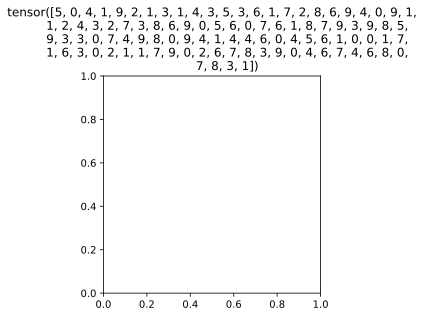

In [109]:
# Hyperparametes
batch_size = 100


# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=True,\
                                        download=False,transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/',train=False,\
                                        download=False,transform=transforms.ToTensor())
print(len(train_data))
#print(train_data[0])

# Load Data
train_data_iterator = Data.DataLoader(train_data,batch_size)
test_data_iterator = Data.DataLoader(test_data,batch_size)

# Visulize Data
img_exmp, label_exmp = iter(train_data_iterator).next()
print(img_exmp.size())
print(label_exmp)

def show_image(img, label):
    d2dl.use_svg_display() 
    plt.title(label)
    plt.xlabel
    plt.imshow(img.view(img.size(1),img.size(1),-1).numpy())

def show_multiple_image(figs, imgs, labels):
    d2dl.use_svg_display() 
    _,figs = plt.subplots(1,len(imgs))  # ,figsize=(12,12)
    for fig,img,label in zip(figs,imgs,labels):
        fig.imshow(img.view(img.size(1),img.size(1),-1).numpy())
        fig.title(label)
        
        

show_image(img_exmp,label_exmp)

# Define Model


# Train Model

# Test Model

# Predict

## Softmax with MNIST dataset (image classification)

In [72]:
import torch
from torch import nn
from torch.utils import data as Data 
from torch import optim as optim
from torch.nn import init

import torchvision
from torchvision import transforms as transforms

from matplotlib import pyplot as plt

In [74]:
# Hyperparameters
batch_size = 100
learning_rate = 0.001
num_epochs = 5
num_features = 784
num_classes = 10


# Obtain Data
train_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/', train=True,\
                                        transform=transforms.ToTensor(),download=True)

test_data = torchvision.datasets.MNIST(root='/Users/yanzheyuan/coding/dataset_pytorch/', train=False,\
                                        transform=transforms.ToTensor())

# Load Data
train_data_iterator = Data.DataLoader(train_data, batch_size, shuffle=True)
test_data_iterator = Data.DataLoader(test_data, batch_size, shuffle=True)

# Define Model
net = nn.Sequential()
net.add_module('linear',nn.Linear(num_features,num_classes))
print(net[0])

loss_func = nn.CrossEntropyLoss()
optimizor = optim.SGD(net.parameters(),lr=learning_rate)

# Train Model

# initial the parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

print('start training......')
total_step = len(train_data_iterator)
for epoch in range(num_epochs):
    for step,(img,label) in enumerate(train_data_iterator):
        # reshape image to (batch_size, 28, 28)
        img = img.reshape(-1,28*28)
        
        output = net(img)
        loss = loss_func(output, label)
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
        
        # print intermediate results
        if (step+1) % 100 == 0: 
            print('Epoch: %d/%d, Step:%d/%d, CE_Loss: %f' %(epoch+1,num_epochs,step+1,total_step,loss.item()))
print('training done......')

# Test Model
print('start testing......')
with torch.no_grad():
    correct = 0
    total = 0
    for img,label in test_data_iterator:
        img = img.reshape(-1,28*28)
        
        output = net(img)
        total += img.size(0)
        _, predicted = torch.max(output,1)
        correct += (label==predicted).sum(0)
    print('total accuracy is: %f' %(100 * correct / total))



<class 'torch.Tensor'>
torch.Size([1, 28, 28])
5
Linear(in_features=784, out_features=10, bias=True)
start training......
Epoch: 1/5, Step:100/600, CE_Loss: 2.207091
Epoch: 1/5, Step:200/600, CE_Loss: 2.100751
Epoch: 1/5, Step:300/600, CE_Loss: 2.046311
Epoch: 1/5, Step:400/600, CE_Loss: 1.984010
Epoch: 1/5, Step:500/600, CE_Loss: 1.834322
Epoch: 1/5, Step:600/600, CE_Loss: 1.804602
Epoch: 2/5, Step:100/600, CE_Loss: 1.732876
Epoch: 2/5, Step:200/600, CE_Loss: 1.572720
Epoch: 2/5, Step:300/600, CE_Loss: 1.617251
Epoch: 2/5, Step:400/600, CE_Loss: 1.486061
Epoch: 2/5, Step:500/600, CE_Loss: 1.522531
Epoch: 2/5, Step:600/600, CE_Loss: 1.487520
Epoch: 3/5, Step:100/600, CE_Loss: 1.417289
Epoch: 3/5, Step:200/600, CE_Loss: 1.317358
Epoch: 3/5, Step:300/600, CE_Loss: 1.306909
Epoch: 3/5, Step:400/600, CE_Loss: 1.321009
Epoch: 3/5, Step:500/600, CE_Loss: 1.272637
Epoch: 3/5, Step:600/600, CE_Loss: 1.231227
Epoch: 4/5, Step:100/600, CE_Loss: 1.204346
Epoch: 4/5, Step:200/600, CE_Loss: 1.19822

## Softmax Regression with Iris dataset

In [24]:
# import packages
import torch
from torch import nn as nn
from torch import optim as optim
from torch.nn import init
from torch.utils import data as Data

import random
import numpy
import d2lzh_pytorch as d2dl

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [78]:
# Try with iris dataset, a 3-type classification task

# Hyperparameters
batch_size = 10
num_epochs = 50
learning_rate = 0.01

# Obtain Data
data = load_iris()
labels = data.target
features = data.data

# split into train and test data
features, features_test, labels, labels_test = train_test_split(features,labels,test_size=0.2,random_state=32)

num_features = len(data.feature_names)
num_examples = features.shape[0]
num_classes = len(np.unique(labels))
print('train:',num_features,num_examples,num_classes)

# Load Data
labels = torch.tensor(labels)
features = torch.Tensor(features)
labels_test = torch.tensor(labels_test)
features_test = torch.Tensor(features_test)
print(labels.dtype)

# train data batch_loader
train_dataset = Data.TensorDataset(features, labels)
train_data_iterator = Data.DataLoader(train_dataset, batch_size, shuffle=True)

# train data batch_loader
test_dataset = Data.TensorDataset(features, labels)
test_data_iterator = Data.DataLoader(test_dataset, batch_size, shuffle=True)

# Define Model
class logistic_regression(nn.Module):
    def __init__(self, num_features, num_classes):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(num_features, num_classes)
    def forward(self, x):
        y = self.linear(x)
        return y

net = logistic_regression(num_features,num_classes) 
print(net)
loss_func = nn.CrossEntropyLoss()  # softmax is built internally, so no need to write softmax layer.
optimizor = optim.SGD(net.parameters(),lr=learning_rate)

# Train Model

# initalize parameters
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

print('start training......')
for epoch in range(num_epochs):
    for X,y in train_data_iterator:
        output = net(X)
        #print(output.size())
        #print(y.view(-1,1).size())
        loss = loss_func(output, y)  
        optimizor.zero_grad()
        loss.backward()
        optimizor.step()
    print ('Epoch [%d/%d], CE_Loss: :%f' %(epoch+1, num_epochs, loss_func(net(features),labels).item()))
print('training done......')
            
# Test Model
print('start testing......')
with torch.no_grad():
    correct = 0
    total = 0
    for X,y in test_data_iterator:
        output = net(X)
        _, predicted = torch.max(output.data, 1)  # torch.max(data, dim) return: the max value, the index
        total += y.size(0)
        correct += (predicted == y).sum()

    print('total accuracy on the test data: %f' %(100 * correct / total))
    




train: 4 120 3
torch.int64
logistic_regression(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)
start training......
Epoch [1/50], CE_Loss: :1.017339
Epoch [2/50], CE_Loss: :0.950067
Epoch [3/50], CE_Loss: :0.904789
Epoch [4/50], CE_Loss: :0.856119
Epoch [5/50], CE_Loss: :0.812372
Epoch [6/50], CE_Loss: :0.785542
Epoch [7/50], CE_Loss: :0.750864
Epoch [8/50], CE_Loss: :0.725631
Epoch [9/50], CE_Loss: :0.705934
Epoch [10/50], CE_Loss: :0.680835
Epoch [11/50], CE_Loss: :0.666132
Epoch [12/50], CE_Loss: :0.646693
Epoch [13/50], CE_Loss: :0.632525
Epoch [14/50], CE_Loss: :0.623475
Epoch [15/50], CE_Loss: :0.606705
Epoch [16/50], CE_Loss: :0.597601
Epoch [17/50], CE_Loss: :0.589159
Epoch [18/50], CE_Loss: :0.576753
Epoch [19/50], CE_Loss: :0.581680
Epoch [20/50], CE_Loss: :0.561432
Epoch [21/50], CE_Loss: :0.551138
Epoch [22/50], CE_Loss: :0.545657
Epoch [23/50], CE_Loss: :0.539730
Epoch [24/50], CE_Loss: :0.530132
Epoch [25/50], CE_Loss: :0.525043
Epoch [26/50], CE_Loss: :0.

## Visualization on generated data

In [47]:
import d2lzh_pytorch as d2dl

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 三维作图  

torch.Size([1000, 3]) torch.Size([1000])


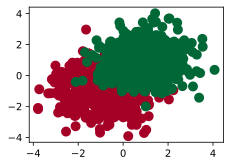

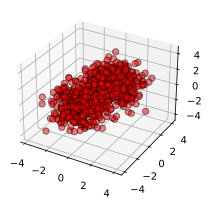

In [46]:
# Generate the data
# since it is a classfication task, we need generate fake data from two distributions
num_examples = 10000
num_features = 3
x_0 = torch.tensor(np.random.normal(-1,1,size=(500,num_features)),dtype=torch.float32)
y_0 = torch.zeros(500)
x_1 = torch.tensor(np.random.normal(1,1,size=(500,num_features)),dtype=torch.float32)
y_1 = torch.ones(500)
#print(x_0)
#print(x_1)
features = torch.cat((x_0,x_1),0)
labels = torch.cat((y_0,y_1),0)
print(features.size(),labels.size())
#print(labels)


# Visualize the data distribution
def visualize_data_2d(features, labels):
    d2dl.use_svg_display()
    d2dl.set_figsize()
    #plt.scatter(features[:,dim],labels,1)
    plt.scatter(features.data.numpy()[:,0], features.data.numpy()[:,1], c=labels.data.numpy(), s=100, lw=0, cmap='RdYlGn')

def visualize_data_3d(features, labels):
    d2dl.use_svg_display()
    d2dl.set_figsize()
    ax = Axes3D(plt.figure())
    NumP = 50
    x = features.data.numpy()[:,0]
    y = features.data.numpy()[:,1]
    z = features.data.numpy()[:,2]
    ax.scatter(x,y,z,s=40,c='r',edgecolor='k',alpha=0.5)

visualize_data_2d(features, labels)
visualize_data_3d(features, labels)